# Example parametric PDE: The Poisson Problem

The usual introductory example is the Poisson problem, having a parametric coefficient function. 
In our setting, we consider a coefficient function $\kappa\in L^\infty([-1, 1]^M; L^\infty(D))$ defined as *AffineField*. 
Furthermore, we take a parametric right-hand side of the problem as well.
Here, defined as another *AffineField*, living on a possibly different parameter domain. 
The solution of the problem
\begin{align}
  -\mathrm{div}\kappa(x, y)\nabla u(x, y, y') &= f(x, y') \quad&\text{in } D\times\Gamma\times\Gamma_f \\
                                  u(x, y, y') &= g(x) \quad&\text{on } \partial D\times\Gamma\times\Gamma_f   
\end{align}
is defined for every parameter tuple $(y, y')\in\Gamma\times\Gamma_f$.

The class *ParametricPoisson* implements the functionality to solve the problem above. 
The coefficient and right hand side parameter dependence is provided by the *AffineField* implementation. See [Coefficient Field demo].

In [1]:
from __future__ import (division, print_function)
from alea.math_utils.param_pde.forward_operator.poisson import ParametricPoisson
from alea.math_utils.param_pde.affine_field import AffineField
import numpy as np
from dolfin import *

import matplotlib.pyplot as plt

%matplotlib notebook

Initially, a Fenics function space must be defined. 
Additionally, the boundary conditions of the problem above must be provided. 
One can use homogeneous Neumann conditions as well.

In [8]:
# mesh = UnitSquareMesh(10, 10)
# alternatively we can use alea template meshes and boundary types
from alea.math_utils.param_pde.mesh_util import get_mesh, get_boundary
mesh = get_mesh("lshape", mesh_nodes=1e2)
boundary = get_boundary("dirichlet")

fs = FunctionSpace(mesh, 'CG', 3)
bc = DirichletBC(fs, Constant(0), boundary)

plot(mesh);

refined from 6 to 24 cells
refined from 24 to 96 cells
refined from 96 to 384 cells


Then, we define the parametric fields.
We chose a quadratically decaying coefficient field with cosine modes and a more irregular field for the right-hand side.

In [3]:
coef_param = {
    "coef_type": "cos",                   # type: str
    "amptype": "decay-inf",               # type: str
    "decayexp": 2,                        # type: float
    "gamma": 0.9,                         # type: float
    "freqscale": 1.0,                     # type: float
    "freqskip": 0,                        # type: int
    "scale": 1.0,                         # type: float
    "coef_mean": 1.0,                     # type: float
    "rv_type": "uniform"                  # type: str
}

coef = AffineField(**coef_param)

rhs_param = {
    "coef_type": "sin",                   # type: str
    "amptype": "constant",                # type: str
    "decayexp": 0.1,                      # type: float
    "gamma": 1.0,                         # type: float
    "freqscale": 1.0,                     # type: float
    "freqskip": 0,                        # type: int
    "scale": 1.0,                         # type: float
    "coef_mean": 3.0,                     # type: float
    "rv_type": "uniform"                  # type: str
}

rhs = AffineField(**rhs_param)

<IPython.core.display.Javascript object>


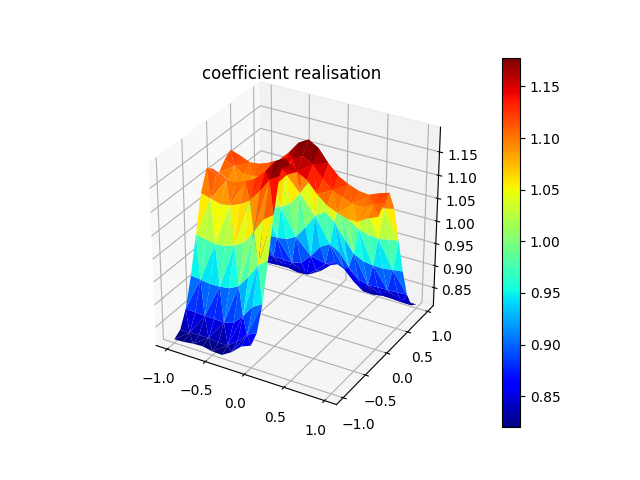

<IPython.core.display.Javascript object>


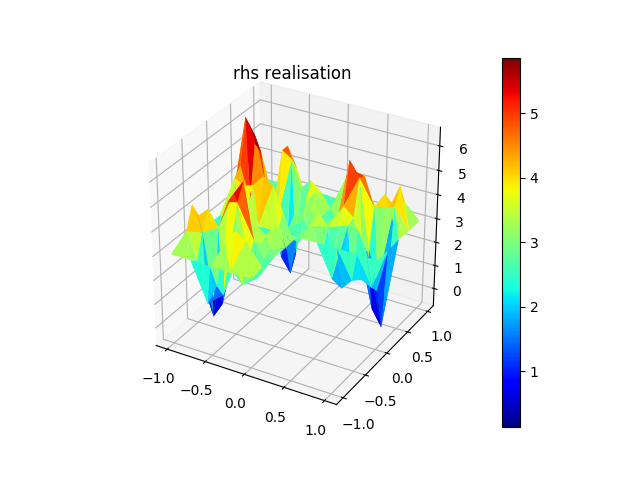

In [4]:
M = 20
y = np.random.rand(M)*2 - 1
y_f = np.random.rand(M)*2 - 1

plt.figure()
im = plot(coef(y, fs, project_result=True), mode="warp")
plt.colorbar(im)
plt.title("coefficient realisation")
plt.figure()
im = plot(rhs(y_f, fs, project_result=True), mode="warp")
plt.colorbar(im)
plt.title("rhs realisation")

plt.show()

Finally, the problem is build and the solve method is used to create sample realisations. 
It is not mandatory to have a parametric right hand side.
If $f\colon D\to\mathbb{R}$ is a deterministic function in $L^2(D)$, everything is fine and you do not need to provide a sample $y'\in\Gamma_f$. 
Instead, consider the right-hand side as a Fenics function or Expression. 

<IPython.core.display.Javascript object>


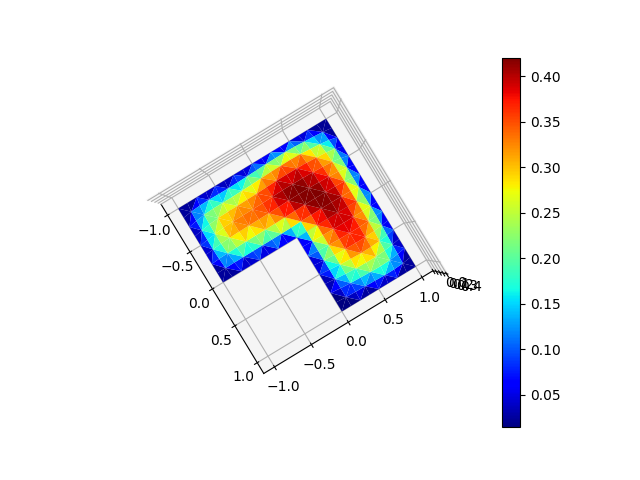

In [9]:
problem = ParametricPoisson(coef, rhs, fs, bc)

solution = problem.solve(y, M, y_f=y_f)
plt.figure()
im = plot(solution, mode="warp")
plt.colorbar(im)
plt.show()

For comparison we compute therelative algebraic $H^1(D)$ error of the coefficient, right-hand side and solution to corresponding reference fields. 
Note that, we only compare the error for one sample. 

In [10]:
stiff = problem.get_stiff_matrix_csr(fs)

ref_coef = coef(y, fs, project_result=True)
ref_coef2 = project(problem.create_expression(y, coef, M), fs)

diff = ref_coef.vector().array() - ref_coef2.vector().array()
rel_err = diff.dot(stiff.dot(diff))/ref_coef2.vector().array().dot(stiff.dot(ref_coef2.vector().array()))

print("error coefficient:{}".format(rel_err))

ref_rhs = rhs(y_f, fs, project_result=True)
ref_rhs2 = project(problem.create_expression(y_f, rhs, M), fs)

diff = ref_rhs.vector().array() - ref_rhs2.vector().array()
rel_err = diff.dot(stiff.dot(diff))/ref_rhs2.vector().array().dot(stiff.dot(ref_rhs2.vector().array()))
print("error rhs: {}".format(rel_err))


error coefficient:1.32566798908e-26
error rhs: 4.59049099818e-31


<IPython.core.display.Javascript object>


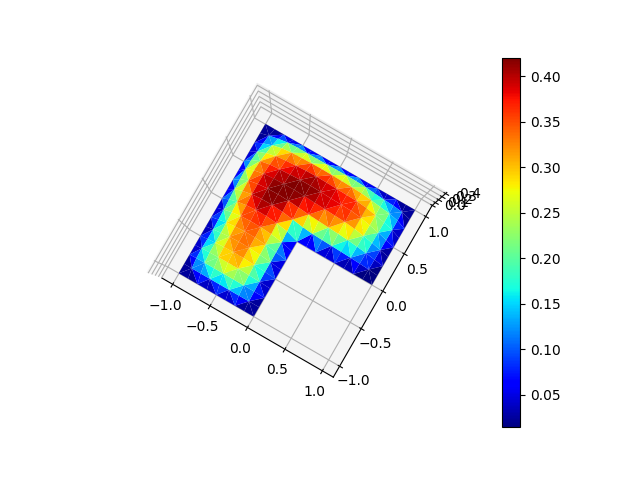

relative H1 error: 2.09807351288e-14


In [11]:
u, v = TrialFunction(fs), TestFunction(fs)
bf = inner(ref_coef* nabla_grad(u), nabla_grad(v))*dx
lf = inner(ref_rhs, v)*dx
ref_sol = Function(fs)
solve(bf==lf, ref_sol, bc)

plt.figure()
im = plot(ref_sol, mode="warp")
plt.colorbar(im)
plt.show()
diff = solution.vector().array() - ref_sol.vector().array()
rel_err = diff.dot(stiff.dot(diff))/ref_sol.vector().array().dot(stiff.dot(ref_sol.vector().array()))
print("relative H1 error: {}".format(rel_err))